# Example notebook for reading and plotting CM1 netcdf output

## Imports


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Define where your output file is and read it in

I've put the output for each run into its own directory, which is a good practice so you don't accidentally overwrite them. Or even better, you can run the model itself from separate directories for each run; just copy or symlink the cm1.exe executable and other needed files into each directory

In [2]:
run_name = "bubble_10km_nowind"
#run_name = "bubble_3km_nowind"

data = xr.open_dataset(run_name+"/cm1out.nc")

#data  ## this will print the metadata for your file

## Set up some variables to see what the times and heights are

In [3]:
times = data['time']
heights = data['zh']
heights_f = data['zf']
num_times = len(times)

heights 

<xarray.DataArray 'zh' (zh: 50)>
array([ 0.052892,  0.161734,  0.27687 ,  0.398666,  0.527505,  0.663795,
        0.807967,  0.960477,  1.121807,  1.292467,  1.472997,  1.663967,
        1.865982,  2.079679,  2.305735,  2.544865,  2.797824,  3.065413,
        3.348476,  3.64791 ,  3.964661,  4.29973 ,  4.654177,  5.029123,
        5.425753,  5.845321,  6.289153,  6.758653,  7.250001,  7.750001,
        8.25    ,  8.75    ,  9.25    ,  9.75    , 10.250001, 10.750001,
       11.250001, 11.750001, 12.250001, 12.750001, 13.250001, 13.750001,
       14.250001, 14.750001, 15.250001, 15.750001, 16.25    , 16.75    ,
       17.25    , 17.75    ], dtype=float32)
Coordinates:
  * zh       (zh) float32 0.05289 0.1617 0.2769 0.3987 ... 16.75 17.25 17.75
Attributes:
    long_name:  nominal height of scalar grid points
    units:      km
    axis:       Z

## We might want to just focus on a subset of the domain, set that up here, and also slice the desired variables to that subset

In [4]:
## slice the fields down that we want to use
xstart = -15  ## in km
xend = 15
ystart = -15
yend = 15

## use this if you want the full domain
#xstart = data['xh'][0].values
#xend = data['xh'][-1].values
#ystart = data['yh'][0].values
#yend = data['yh'][-1].values

## because the scalar variables are on xh,yh,zh, we'll use those for slicing
x = data['xh'].sel(xh=slice(xstart,xend))
y = data['yh'].sel(yh=slice(ystart,yend))

## read in a few key variables
uuu = data['uinterp'].sel(xh=slice(xstart,xend),yh=slice(ystart,yend))
vvv = data['vinterp'].sel(xh=slice(xstart,xend),yh=slice(ystart,yend))
www = data['winterp'].sel(xh=slice(xstart,xend),yh=slice(ystart,yend))
ppert = data['prspert'].sel(xh=slice(xstart,xend),yh=slice(ystart,yend))
thpert = data['thpert'].sel(xh=slice(xstart,xend),yh=slice(ystart,yend))



## Map of vertical velocity and wind vectors at a specified height

working on 14.0 minutes, 5.03 km


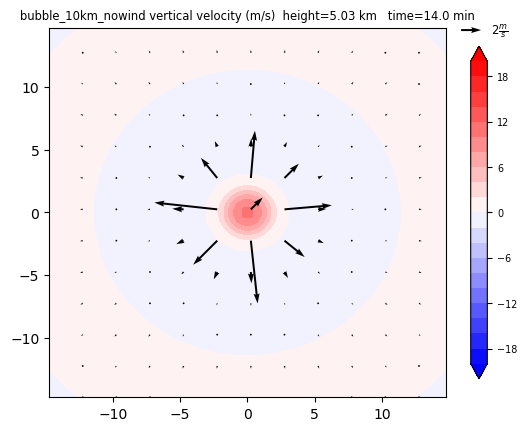

In [5]:
height = 5.  ## the height we want (in km); the code will find the nearest level to this
this_height = np.round(data['zh'].sel(zh=height, method='nearest').values,2)

#for tt in range(0,num_times):  ## loop over all the available times
for tt in range(14,15): ## just a specific time

    this_time = times[tt]
    this_time_minutes = this_time.dt.seconds.values/60.
    print("working on "+str(this_time_minutes)+ " minutes, "+str(this_height)+" km")
    
    fig, ax = plt.subplots()

    ## color contoured vertical velocity
    cf = plt.contourf(x,y,www.sel(time=this_time,zh=height, method='nearest'),
                levels=np.arange(-20,22,2), cmap='bwr', extend='both')
    
    ## vectors every nth gridpoint
    skip = 5  ## if this is 10, plot vector every 10th gridpoint

    ## create grid for x and y points
    x_vec, y_vec = np.meshgrid(x[::skip],y[::skip])

    ## plot the vectors
    vec = plt.quiver(x_vec,y_vec,uuu.sel(time=this_time,zh=height, method='nearest')[::skip,::skip],
                     vvv.sel(time=this_time,zh=height, method='nearest')[::skip,::skip],
                     scale=10.0, scale_units='inches')
    
    ## and the key vector
    qk = ax.quiverkey(vec, 0.8, 0.875, 2.0, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure', fontproperties={'size':'small'})
    
    cb = plt.colorbar(cf, ax=ax, shrink=0.9)
    cb.ax.tick_params(labelsize='x-small')

    ## add a title
    plt.title(run_name+" vertical velocity (m/s)  height="+str(this_height)+" km   time="+str(this_time_minutes)+ " min", fontsize='small')
    
    ## save the figure
    plt.savefig(run_name+"/www_"+str(this_height)+"km_"+"{:04d}".format(int(this_time_minutes))+".png", 
                              bbox_inches='tight',dpi=150, facecolor='white')

    ## uncomment this if you want to see the image in the notebook, comment it if you're doing a loop
    plt.show()
    
    plt.close()

## make a cross section through the storm - vertical velocity and pressure perturbation

working on 14.0 minutes


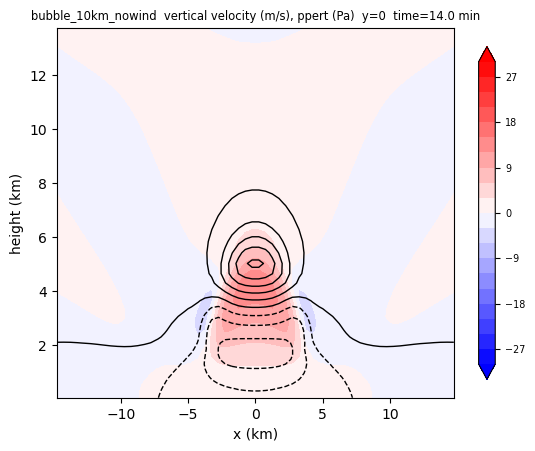

In [6]:
this_y = 0 ## location that we want to take a slice through 
           ##  here setting constant y, so it's a west-east cross-section
    
## bottom and top of the cross section in height; in km
z_bot = 0
z_top = 14 

#for tt in range(0,num_times):  ## loop over all the times
for tt in range(14,15): ## just a specific time

    this_time = times[tt]
    this_time_minutes = this_time.dt.seconds.values/60.
    print("working on "+str(this_time_minutes)+ " minutes")
    
    fig, ax = plt.subplots()

    ## color contoured vertical velocity
    cf = plt.contourf(y,heights.sel(zh=slice(z_bot,z_top)),
                      www.sel(time=this_time,yh=this_y, method='nearest').sel(zh=slice(z_bot,z_top)),
                      levels=np.arange(-30,33,3), cmap='bwr', extend='both')
    
    ## add pressure perturbations
    cf2 = plt.contour(y,heights.sel(zh=slice(z_bot,z_top)),
                      ppert.sel(time=this_time,yh=this_y, method='nearest').sel(zh=slice(z_bot,z_top)),
                      levels=np.arange(-250,275,25), colors='black', linewidths=1.0)
       
    plt.xlabel("x (km)")
    plt.ylabel("height (km)")
    
    cb = plt.colorbar(cf, ax=ax, shrink=0.9)
    cb.ax.tick_params(labelsize='x-small')
    
    plt.title(run_name+"  vertical velocity (m/s), ppert (Pa)  y="+str(this_y)+"  time="+str(this_time_minutes)+ " min", fontsize='small')
    
    plt.savefig(run_name+"/xsec_www_ppert_"+"{:04d}".format(int(this_time_minutes))+".png", 
                              bbox_inches='tight',dpi=150, facecolor='white')
    
    ## uncomment this if you want to see the image in the notebook, comment it if you're doing a loop
    plt.show()

    plt.close()